# Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import sqlite3
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt

# Abrindo arquivos csv

> ETL (extract): após o processo de extração dos dados do Kaggle.

In [2]:
olist_customers = pd.read_csv('data/olist_customers_dataset.csv', index_col=0)
olist_geolocation = pd.read_csv('data/olist_geolocation_dataset.csv', index_col=0)
olist_order_items = pd.read_csv('data/olist_order_items_dataset.csv', index_col=0)
olist_order_payments = pd.read_csv('data/olist_order_payments_dataset.csv', index_col=0)
olist_order_reviews = pd.read_csv('data/olist_order_reviews_dataset.csv', index_col=0)
olist_orders = pd.read_csv('data/olist_orders_dataset.csv', index_col=0)
olist_products = pd.read_csv('data/olist_products_dataset.csv', index_col=0)
olist_sellers = pd.read_csv('data/olist_sellers_dataset.csv', index_col=0)
product_category_name = pd.read_csv('data/product_category_name_translation.csv', index_col=0)

# Inspecionando os dados

In [3]:
dfs = {
    'olist_customers': olist_customers,
    'olist_geolocation': olist_geolocation,
    'olist_order_items': olist_order_items,
    'olist_order_payments': olist_order_payments,
    'olist_order_reviews': olist_order_reviews,
    'olist_orders': olist_orders,
    'olist_products': olist_products,
    'olist_sellers': olist_sellers,
    'product_category_name': product_category_name
}

> Checando as dimensões dos dados.

In [4]:
for name, df in dfs.items():
    print(f'{name}: {df.shape}')

olist_customers: (99441, 4)
olist_geolocation: (1000163, 4)
olist_order_items: (112650, 6)
olist_order_payments: (103886, 4)
olist_order_reviews: (99224, 6)
olist_orders: (99441, 7)
olist_products: (32951, 8)
olist_sellers: (3095, 3)
product_category_name: (71, 1)


> Checando dados nulos.

In [5]:
def count_nulls(column):
    return column.isna().sum()

In [6]:
for df_name, df in dfs.items():
    null_counts = df.isnull().sum()
    print(f'tabela: {df_name}')
    print('-' * 50)
    print(null_counts)
    print('-' * 50)

tabela: olist_customers
--------------------------------------------------
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
--------------------------------------------------
tabela: olist_geolocation
--------------------------------------------------
geolocation_lat      0
geolocation_lng      0
geolocation_city     0
geolocation_state    0
dtype: int64
--------------------------------------------------
tabela: olist_order_items
--------------------------------------------------
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
--------------------------------------------------
tabela: olist_order_payments
--------------------------------------------------
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64
--------------------

In [7]:
for tabela, df in dfs.items():
    print(f'Informações sobre a tabela {tabela}:')
    print('-' * 50)
    print(df.info())
    print('-' * 50)

Informações sobre a tabela olist_customers:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 99441 entries, 06b8999e2fba1a1fbc88172c00ba8bc7 to 274fa6071e5e17fe303b9748641082c8
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_unique_id        99441 non-null  object
 1   customer_zip_code_prefix  99441 non-null  int64 
 2   customer_city             99441 non-null  object
 3   customer_state            99441 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.8+ MB
None
--------------------------------------------------
Informações sobre a tabela olist_geolocation:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000163 entries, 1037 to 99950
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0  

# Transformação dos dados

> ETL (transform): etapa de transformação dos dados.

###### olist_order_reviews

Transformando `review_creation_date` e `review_answer_timestamp` de object para datetime.

In [8]:
olist_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99224 entries, 7bc2406110b926393aa56f80a40eba40 to efe49f1d6f951dd88b51e6ccd4cc548f
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   order_id                 99224 non-null  object
 1   review_score             99224 non-null  int64 
 2   review_comment_title     11568 non-null  object
 3   review_comment_message   40977 non-null  object
 4   review_creation_date     99224 non-null  object
 5   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(5)
memory usage: 5.3+ MB


In [9]:
olist_order_reviews['review_creation_date'] = pd.to_datetime(olist_order_reviews['review_creation_date'])

olist_order_reviews['review_answer_timestamp'] = pd.to_datetime(olist_order_reviews['review_answer_timestamp'])

print(olist_order_reviews.info())

<class 'pandas.core.frame.DataFrame'>
Index: 99224 entries, 7bc2406110b926393aa56f80a40eba40 to efe49f1d6f951dd88b51e6ccd4cc548f
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_id                 99224 non-null  object        
 1   review_score             99224 non-null  int64         
 2   review_comment_title     11568 non-null  object        
 3   review_comment_message   40977 non-null  object        
 4   review_creation_date     99224 non-null  datetime64[ns]
 5   review_answer_timestamp  99224 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 5.3+ MB
None


Removendo colunas de comentários dos clientes `review_comment_title` e `review_comment_message`, pois não serão utilizadas e possuem muitos dados nulos.

In [10]:
olist_order_reviews.drop(['review_comment_title', 'review_comment_message'], axis=1, inplace=True)

###### olist_geolocation

Foi necessário remover a acentuação dos nomes das cidades, pois algumas delas apresentavam dados duplicados em decorrência da presença do nome com e sem acento.

In [11]:
olist_geolocation['geolocation_city'].value_counts()

sao paulo               135800
rio de janeiro           62151
belo horizonte           27805
são paulo                24918
curitiba                 16593
                         ...  
jacuípe                      1
mar vermelho                 1
quebrangulo                  1
poço das trincheiras         1
poxim                        1
Name: geolocation_city, Length: 8011, dtype: int64

In [12]:
olist_geolocation['geolocation_city'] = olist_geolocation['geolocation_city'].str.normalize(
    'NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.lower()

In [13]:
olist_geolocation['geolocation_city'].value_counts()

sao paulo                160719
rio de janeiro            62151
belo horizonte            27805
curitiba                  16593
porto alegre              13521
                          ...  
poxim                         1
luziapolis                    1
sao jose dos salgados         1
martins guimaraes             1
lagoa salgada                 1
Name: geolocation_city, Length: 5968, dtype: int64

###### olist_orders

In [14]:
olist_orders['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

> Dropando colunas com dados nulos `order_approved_at`, `order_delivered_carrier_date` e `order_delivered_customer_date`, pois não serão utilizadas na análise.

In [15]:
olist_orders.drop(['order_purchase_timestamp','order_approved_at',
                   'order_delivered_carrier_date','order_delivered_customer_date',
                   'order_estimated_delivery_date'],axis=1, inplace=True)

In [16]:
olist_orders.columns

Index(['customer_id', 'order_status'], dtype='object')

###### olist_products

Verificando dados nulos na coluna `product_category_name`.

In [17]:
olist_products['product_category_name'].unique()

array(['perfumaria', 'artes', 'esporte_lazer', 'bebes',
       'utilidades_domesticas', 'instrumentos_musicais', 'cool_stuff',
       'moveis_decoracao', 'eletrodomesticos', 'brinquedos',
       'cama_mesa_banho', 'construcao_ferramentas_seguranca',
       'informatica_acessorios', 'beleza_saude', 'malas_acessorios',
       'ferramentas_jardim', 'moveis_escritorio', 'automotivo',
       'eletronicos', 'fashion_calcados', 'telefonia', 'papelaria',
       'fashion_bolsas_e_acessorios', 'pcs', 'casa_construcao',
       'relogios_presentes', 'construcao_ferramentas_construcao',
       'pet_shop', 'eletroportateis', 'agro_industria_e_comercio', nan,
       'moveis_sala', 'sinalizacao_e_seguranca', 'climatizacao',
       'consoles_games', 'livros_interesse_geral',
       'construcao_ferramentas_ferramentas',
       'fashion_underwear_e_moda_praia', 'fashion_roupa_masculina',
       'moveis_cozinha_area_de_servico_jantar_e_jardim',
       'industria_comercio_e_negocios', 'telefonia_fixa',
   

> Checando se Todas as linhas do `product_id` são únicas. O índice foi transformado de product_id para o índice numérico padrão.

In [18]:
olist_products.shape

(32951, 8)

In [19]:
products = olist_products.reset_index()

products = products['product_id']

products.nunique()

32951

> Como todas as linhas do conjunto de dados são exclusivas e nenhum nome de produto com dados nulos foi repetido, não há valores nulos que possam ser transformados. Sendo assim, a melhor opção foi removê-los.

In [20]:
olist_products['product_category_name'].dropna(inplace=True)

> As colunas abaixo tratam das dimensões dos produtos e não são de interesse para essa visualização de dados, por isso foram removidas.

In [21]:
olist_products.drop(['product_name_lenght','product_description_lenght','product_photos_qty',
                     'product_weight_g','product_length_cm', 'product_height_cm',
                     'product_width_cm'], axis=1, inplace=True)

In [22]:
olist_products.columns

Index(['product_category_name'], dtype='object')

# Criando o banco de dados

> ETL - load: Etapa de carregamento com a criação do banco de dados.

Conexão do banco de dados.

In [23]:
conn = sqlite3.connect('olist.db')

Criando as tabelas do banco de dados.

In [24]:
olist_customers.to_sql(name='olist_customers', con=conn, if_exists='replace')
olist_geolocation.to_sql(name='olist_geolocation', con=conn, if_exists='replace')
olist_order_items.to_sql(name='olist_order_items',con=conn, if_exists='replace')
olist_order_payments.to_sql(name='olist_order_payments', con=conn, if_exists='replace')
olist_order_reviews.to_sql(name='olist_order_reviews', con=conn, if_exists='replace')
olist_orders.to_sql(name='olist_orders', con=conn, if_exists='replace')
olist_products.to_sql(name='olist_products', con=conn, if_exists='replace')
olist_sellers.to_sql(name='olist_sellers', con=conn, if_exists='replace')
#product_category_name.to_sql(name='product_category_name', con=conn, if_exists='replace')

3095

Checando as tabelas presentes no banco de dados.

In [25]:
!sqlite3 olist.db '.tables'

olist_customers       olist_order_payments  olist_products      
olist_geolocation     olist_order_reviews   olist_sellers       
olist_order_items     olist_orders        


Verificando informações das tabelas do banco de dados `olist.db`.

In [26]:
!sqlite3 olist.db 'PRAGMA table_info(olist_customers)'

0|customer_id|TEXT|0||0
1|customer_unique_id|TEXT|0||0
2|customer_zip_code_prefix|INTEGER|0||0
3|customer_city|TEXT|0||0
4|customer_state|TEXT|0||0


# MER (Modelo Entidade-Relacionamento)

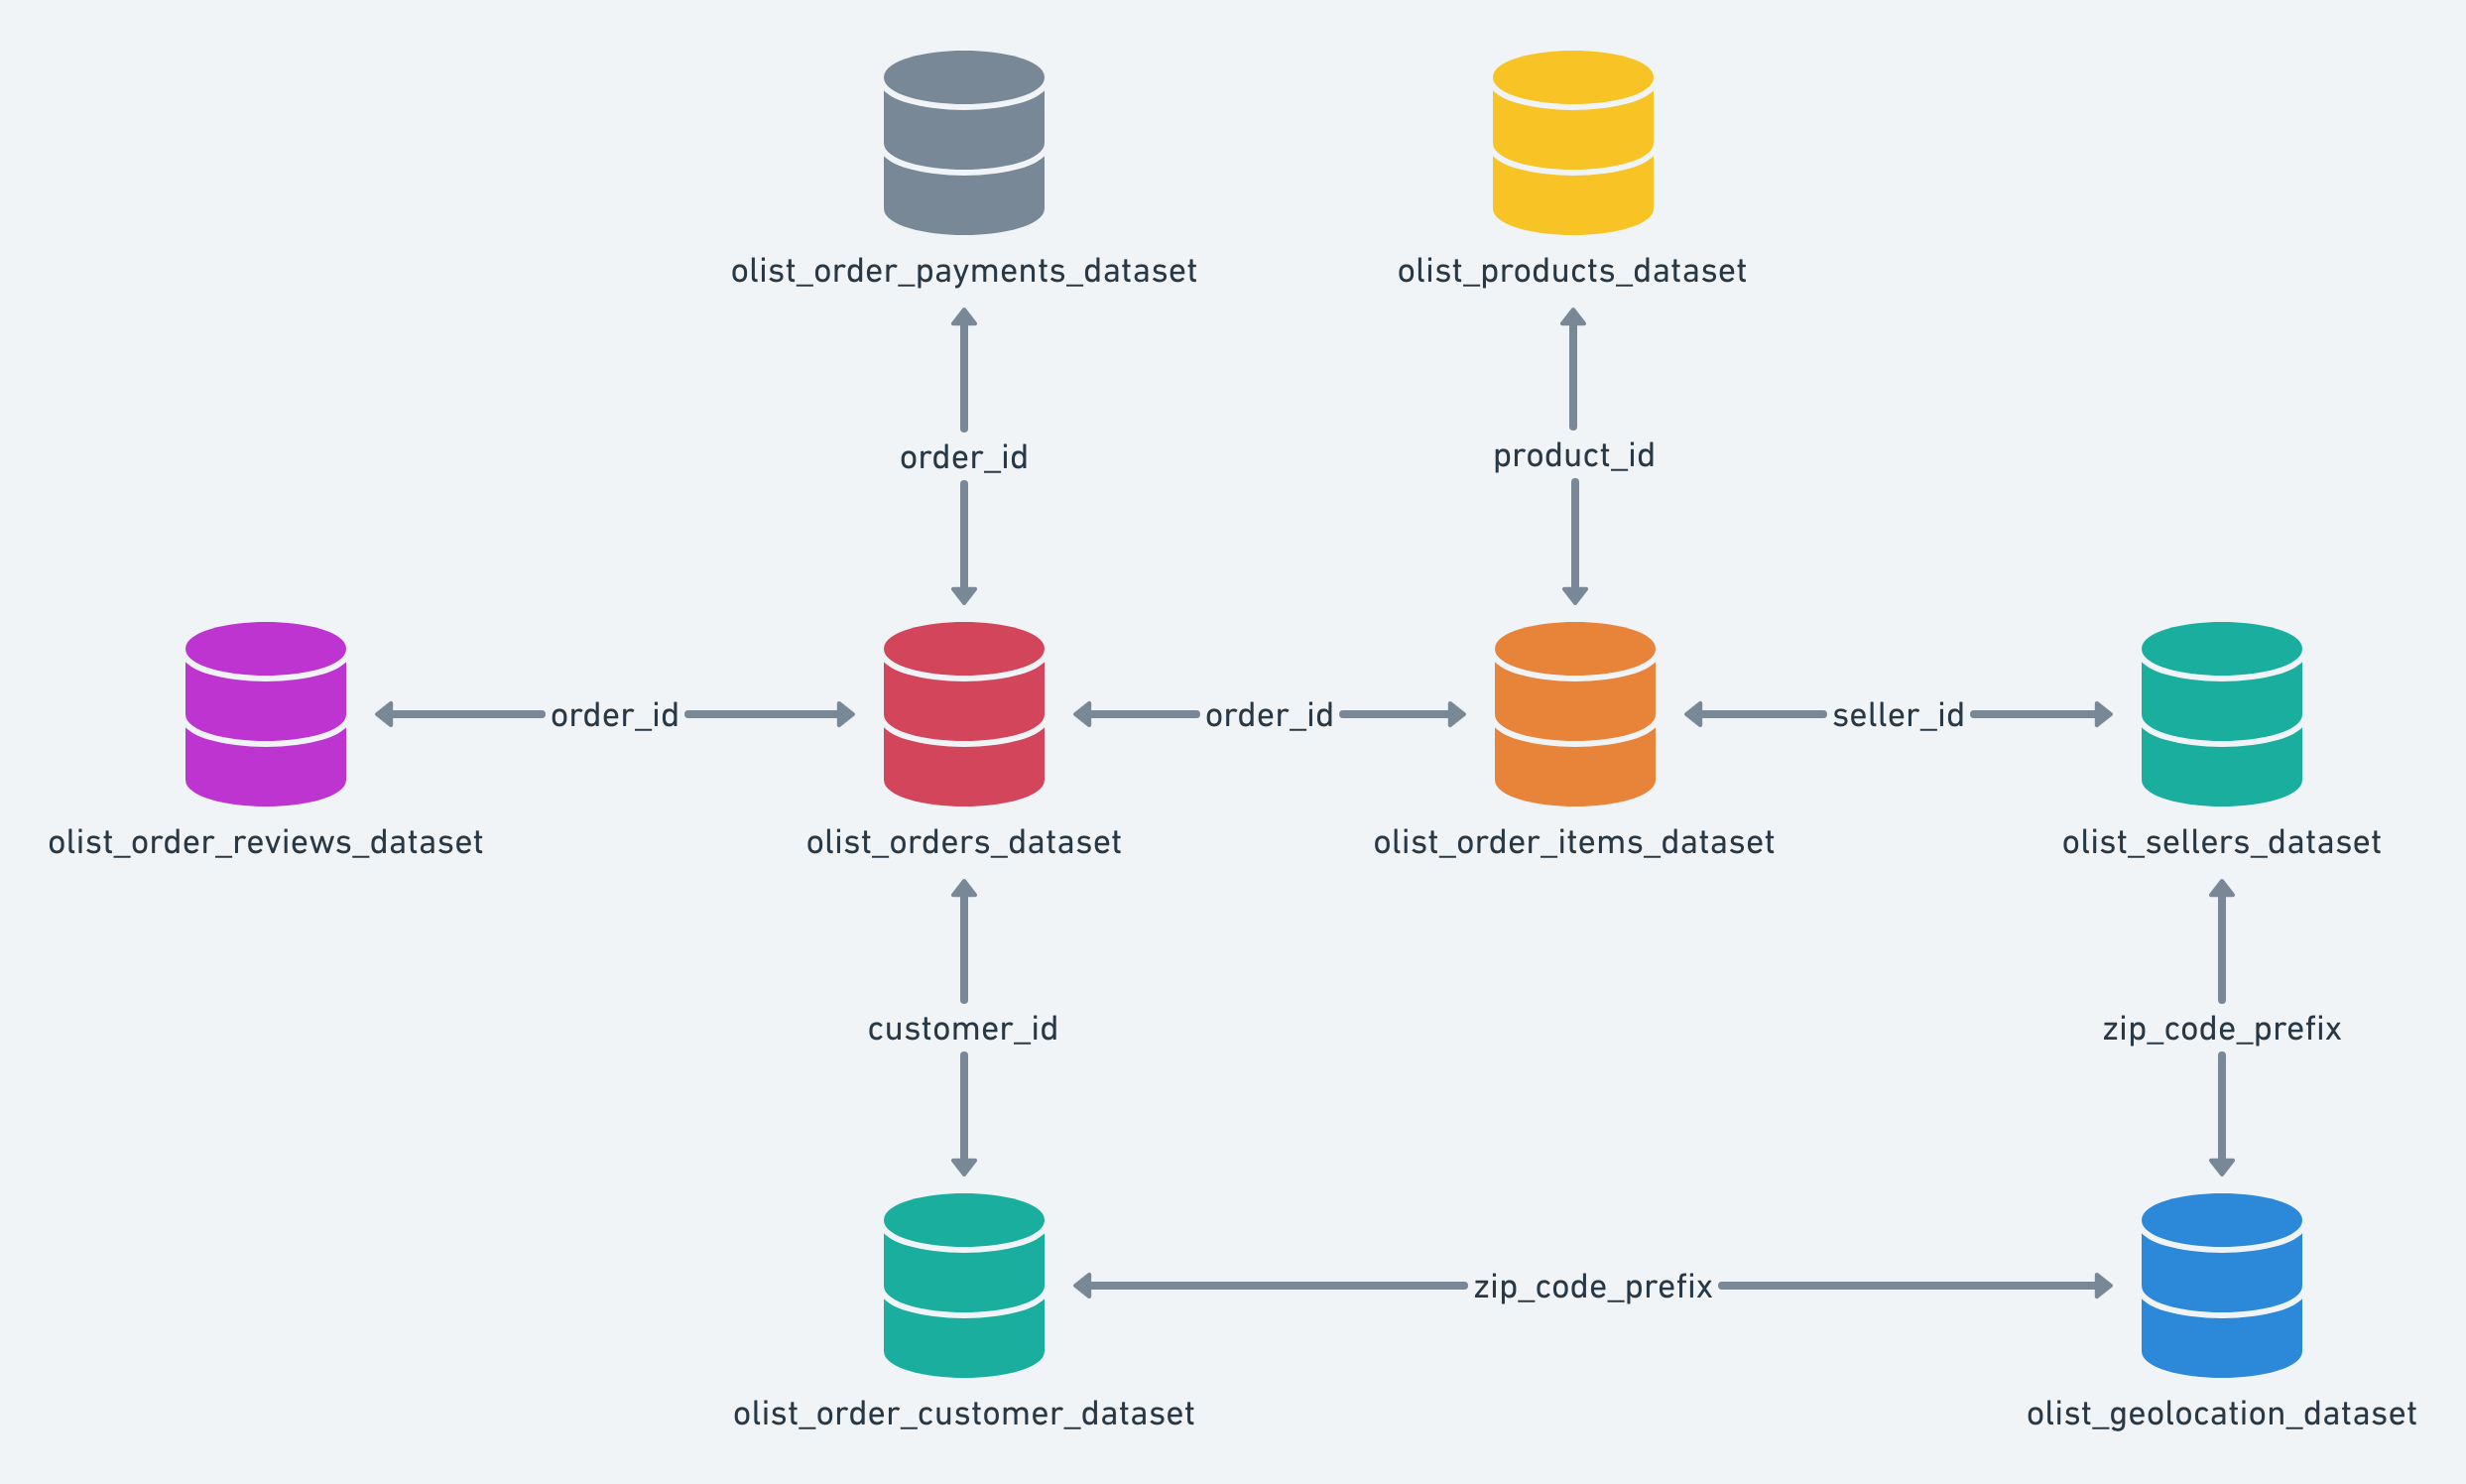

In [27]:
Image("img/MER.png")

# Lista de queries

> #### 1. Total de estados registrados.

>#### 2. Quantidade de cidades por estado.

>#### 3. Total de produtos cadastrados.

>#### 4. Número de pedidos por estado.

>#### 5. Top 10 cidades com mais pedidos em Minas Gerais e São Paulo.

>#### 6. Categorias de produto que mais venderam em Minas Gerais e São Paulo.

>#### 7. Quantidade de vendedores por estado.

>#### 8. Quantidade de pedidos por status de pedido.

>#### 9. Quantidade de pedidos entregues e quantidade de pedidos cancelados.

>#### 10.Quantidade de pedidos por tipo de pagamento.

>#### 11. Preço máximo, mínimo e médio dos valores de pedidos feitos com cartão de crédito.

>#### 12. Média do frete por categoria do produto.

>#### 13. Total de pedidos cadastrados.

>#### 14. Distribuição de reviews dos pedidos.

>#### 15. Ano em que mais enviou produtos.

# Queries com SQL

## 1. Total de estados registrados

> Consulta SQL.

In [28]:
query = """

        SELECT COUNT(DISTINCT(geolocation_state)) AS estados_registrados
        
        FROM olist_geolocation;

        """

geolocation_state = pd.read_sql(query, con=conn)
geolocation_state

,estados_registrados
0,27


## 2. Quantidade de cidades por estado

> Consulta SQL.

In [29]:
query = """

        SELECT COUNT(DISTINCT geolocation_city) AS cidades_registradas, geolocation_state AS estados_registrados
        
        FROM olist_geolocation 
        
        GROUP BY geolocation_state 
        
        ORDER BY COUNT(DISTINCT geolocation_city) DESC;

        """

geolocation_city = pd.read_sql(query, con=conn)
geolocation_city

,cidades_registradas,estados_registrados
0,1091,MG
1,760,SP
2,524,RS
3,477,BA
4,470,PR
5,313,SC
6,257,GO
7,222,MA
8,212,CE
9,210,PE


In [30]:
sns.set_style('whitegrid',{'grid.color': '.7','grid.linestyle': ':'})

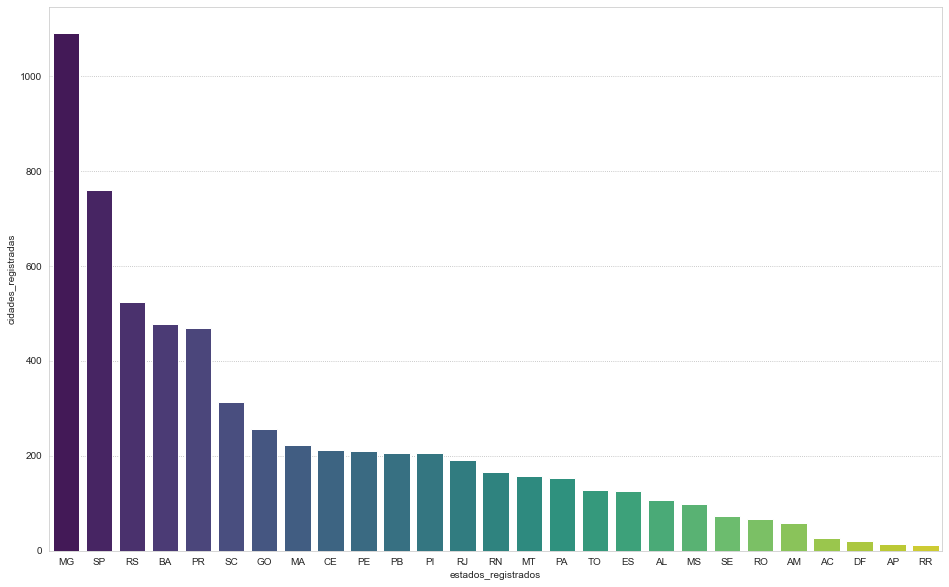

In [31]:
plt.figure(figsize=(16, 10))
sns.barplot(x='estados_registrados', y='cidades_registradas',data=geolocation_city, palette='viridis')
plt.show()

## 3. Total de produtos cadastrados

> Consulta SQL.

In [32]:
query = """

        SELECT COUNT(DISTINCT(product_id)) AS total_produtos
        
        FROM olist_products;

        """

products = pd.read_sql(query, con=conn)
products

,total_produtos
0,32951


## 4. Número de pedidos por estado

> Consulta SQL.

In [33]:
!sqlite3 olist.db '.tables'

olist_customers       olist_order_payments  olist_products      
olist_geolocation     olist_order_reviews   olist_sellers       
olist_order_items     olist_orders        


In [34]:
query = """
        SELECT g.geolocation_state AS estados, COUNT(DISTINCT o.order_id) AS num_pedidos

        FROM olist_orders o
        INNER JOIN olist_order_items oi ON o.order_id = oi.order_id
        INNER JOIN olist_sellers s ON oi.seller_id = s.seller_id
        INNER JOIN olist_geolocation g ON s.seller_zip_code_prefix = g.geolocation_zip_code_prefix

        GROUP BY g.geolocation_state

        ORDER BY num_pedidos DESC;
        """

order_states = pd.read_sql(query, con=conn)
order_states

,estados,num_pedidos
0,SP,69493
1,MG,8045
2,PR,7773
3,RJ,4497
4,SC,3831
5,RS,1993
6,DF,789
7,BA,572
8,GO,463
9,PE,406


> Transformando em escala logarítmica para visualizar melhor os pedidos por estado.

In [35]:
order_states['num_pedidos'] = np.log1p(order_states['num_pedidos'])

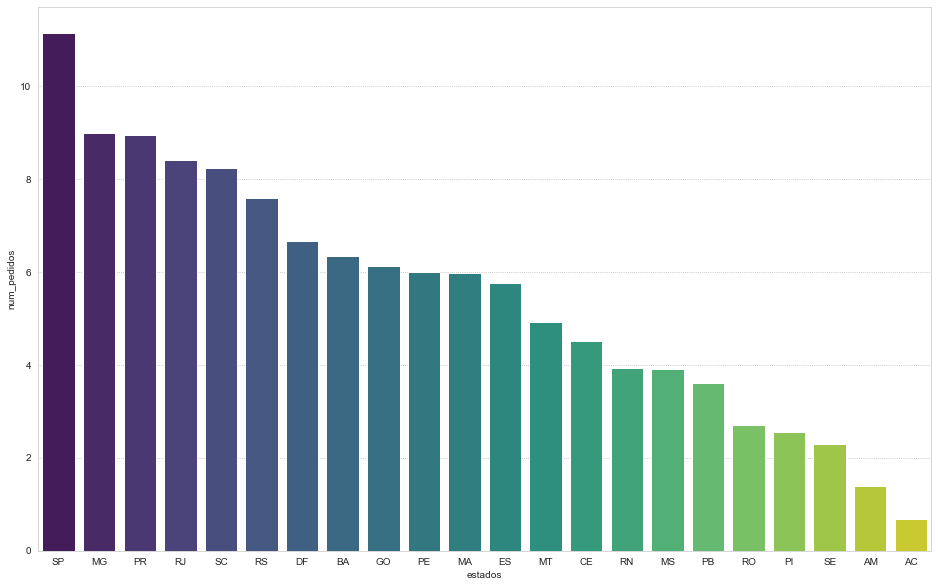

In [36]:
plt.figure(figsize=(16, 10))
sns.barplot(x='estados', y='num_pedidos', data=order_states, palette='viridis')
plt.show()

## 5. Top 10 cidades com mais pedidos em MG e SP

> Consulta SQL.

In [37]:
query = """
        SELECT g.geolocation_city AS cidades, COUNT(DISTINCT o.order_id) AS num_pedidos

        FROM olist_orders o
        INNER JOIN olist_order_items oi ON o.order_id = oi.order_id
        INNER JOIN olist_sellers s ON oi.seller_id = s.seller_id
        INNER JOIN olist_geolocation g ON s.seller_zip_code_prefix = g.geolocation_zip_code_prefix
        
        WHERE g.geolocation_state = 'MG'

        GROUP BY g.geolocation_city

        ORDER BY num_pedidos DESC;
        
        """

order_cities_mg = pd.read_sql(query, con=conn)
order_cities_mg.head(10)

,cidades,num_pedidos
0,belo horizonte,2426
1,ilicinea,718
2,araguari,477
3,borda da mata,471
4,uberlandia,355
5,betim,271
6,monte siao,247
7,sete lagoas,246
8,tres coracoes,222
9,uba,203


In [38]:
top10mg = order_cities_mg.loc[:9].sort_values('num_pedidos', ascending=True)

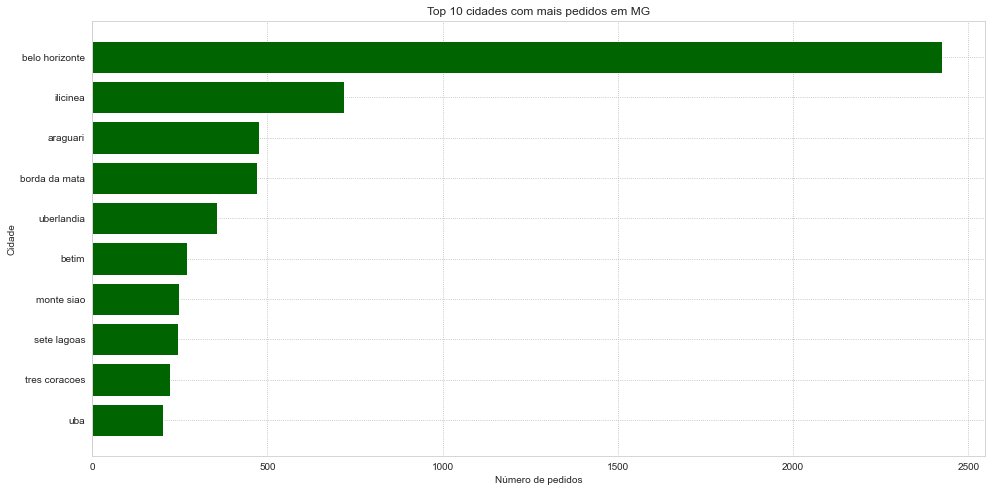

In [39]:
plt.figure(figsize=(16, 8))
plt.barh(top10mg['cidades'], top10mg['num_pedidos'], color='darkgreen')
plt.xlabel('Número de pedidos')
plt.ylabel('Cidade')
plt.title('Top 10 cidades com mais pedidos em MG')
plt.show()

In [40]:
query = """
        SELECT g.geolocation_city AS cidades, COUNT(DISTINCT o.order_id) AS num_pedidos

        FROM olist_orders o
        INNER JOIN olist_order_items oi ON o.order_id = oi.order_id
        INNER JOIN olist_sellers s ON oi.seller_id = s.seller_id
        INNER JOIN olist_geolocation g ON s.seller_zip_code_prefix = g.geolocation_zip_code_prefix
        
        WHERE g.geolocation_state = 'SP'

        GROUP BY g.geolocation_city

        ORDER BY num_pedidos DESC;
        
        """

order_cities_sp = pd.read_sql(query, con=conn)
order_cities_sp.head(10)

,cidades,num_pedidos
0,sao paulo,24758
1,ibitinga,6565
2,santo andre,2737
3,ribeirao preto,2317
4,guarulhos,2088
5,sao jose do rio preto,2052
6,piracicaba,1633
7,campinas,1294
8,itaquaquecetuba,1241
9,praia grande,1235


In [41]:
top10sp = order_cities_sp.loc[:9].sort_values('num_pedidos', ascending=True)

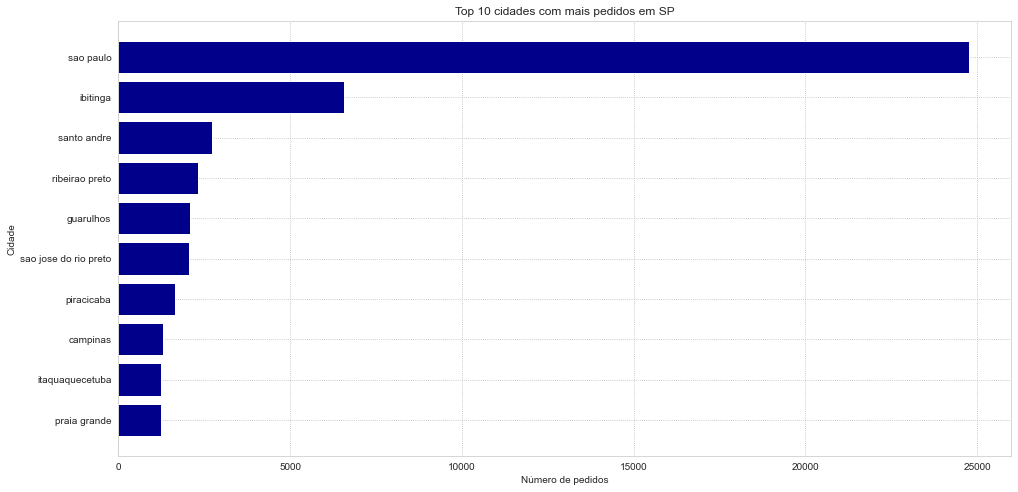

In [42]:
plt.figure(figsize=(16, 8))
plt.barh(top10sp['cidades'], top10sp['num_pedidos'], color='darkblue')
plt.xlabel('Número de pedidos')
plt.ylabel('Cidade')
plt.title('Top 10 cidades com mais pedidos em SP')
plt.show()

## 6. Categorias de produto que mais venderam em  Minas Gerais e  São Paulo

> Consulta SQL.

In [43]:
!sqlite3 olist.db '.tables'

olist_customers       olist_order_payments  olist_products      
olist_geolocation     olist_order_reviews   olist_sellers       
olist_order_items     olist_orders        


In [44]:
query = """
        SELECT p.product_category_name, COUNT(p.product_category_name) AS qtd_produtos

        FROM olist_products p
        INNER JOIN olist_order_items oi ON p.product_id = oi.product_id
        INNER JOIN olist_sellers s ON oi.seller_id = s.seller_id
        INNER JOIN olist_geolocation g ON s.seller_zip_code_prefix = g.geolocation_zip_code_prefix
        
        WHERE g.geolocation_state = 'MG'

        GROUP BY product_category_name

        ORDER BY qtd_produtos DESC
        
        """

product_state_mg = pd.read_sql(query, con=conn)

> Criando uma coluna de porcentagem.

In [45]:
product_state_mg['porcentagem_produtos'] = np.round(product_state_mg['qtd_produtos'] / product_state_mg['qtd_produtos'].sum() * 100,2)

In [46]:
product_state_mg

,product_category_name,qtd_produtos,porcentagem_produtos
0,informatica_acessorios,380220,18.91
1,fashion_bolsas_e_acessorios,185993,9.25
2,utilidades_domesticas,160139,7.96
3,moveis_decoracao,120870,6.01
4,esporte_lazer,107785,5.36
5,pet_shop,104629,5.20
6,beleza_saude,93546,4.65
7,cool_stuff,93113,4.63
8,ferramentas_jardim,90291,4.49
9,automotivo,77322,3.85


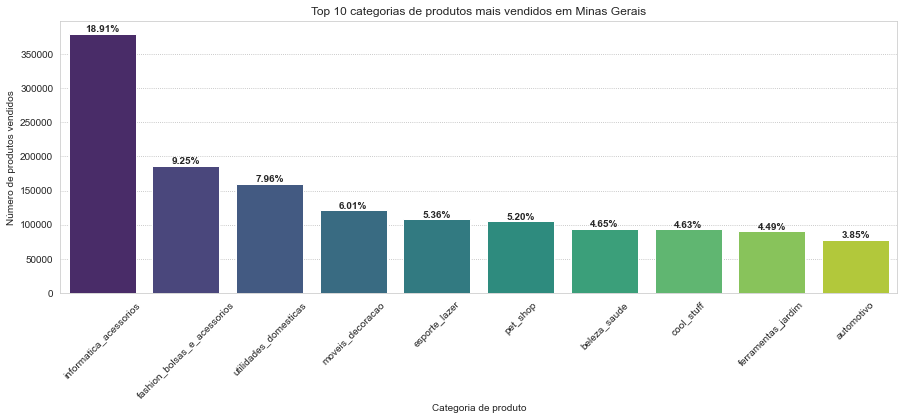

In [47]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x='product_category_name', y='qtd_produtos', data=product_state_mg.loc[:9], palette='viridis')
plt.title('Top 10 categorias de produtos mais vendidos em Minas Gerais')
plt.xlabel('Categoria de produto')
plt.ylabel('Número de produtos vendidos')
plt.xticks(rotation=45)

total_products = product_state_mg["qtd_produtos"].sum()
for i, container in enumerate(ax.containers):
    for j, bar in enumerate(container):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, 
                height+1, 
                f"{height/total_products*100:.2f}%", 
                ha='center', 
                va='bottom', 
                fontsize=10, 
                fontweight='bold')

plt.show()

colocar o percentual nas barras

In [48]:
query = """
        SELECT p.product_category_name, COUNT(p.product_category_name) AS qtd_produtos

        FROM olist_products p
        INNER JOIN olist_order_items oi ON p.product_id = oi.product_id
        INNER JOIN olist_sellers s ON oi.seller_id = s.seller_id
        INNER JOIN olist_geolocation g ON s.seller_zip_code_prefix = g.geolocation_zip_code_prefix
        
        WHERE g.geolocation_state = 'SP'

        GROUP BY product_category_name

        ORDER BY qtd_produtos DESC
        
        """

product_state_sp = pd.read_sql(query, con=conn)

> Criando uma coluna de porcentagem.

In [49]:
product_state_sp['porcentagem_produtos'] = np.round(product_state_sp['qtd_produtos'] / product_state_sp['qtd_produtos'].sum() * 100,2)

product_state_sp

,product_category_name,qtd_produtos,porcentagem_produtos
0,cama_mesa_banho,2182811,20.52
1,beleza_saude,872784,8.20
2,moveis_decoracao,794704,7.47
3,utilidades_domesticas,726950,6.83
4,ferramentas_jardim,685010,6.44
...,...,...,...
69,pc_gamer,1167,0.01
70,la_cuisine,429,0.00
71,seguros_e_servicos,258,0.00
72,fashion_roupa_infanto_juvenil,252,0.00


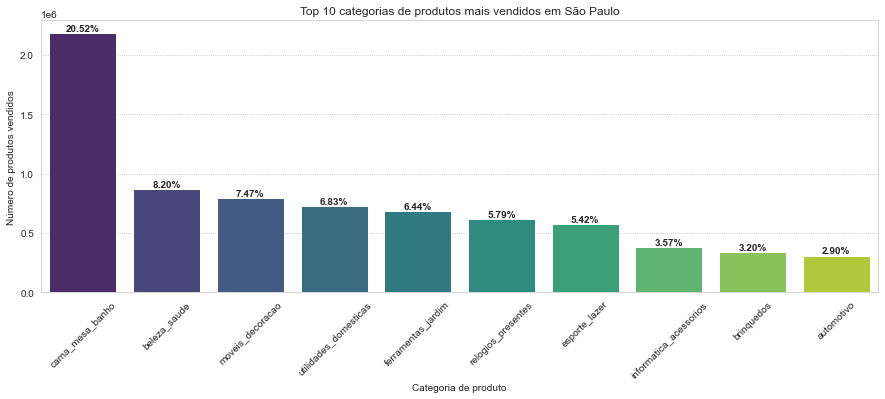

In [50]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x="product_category_name", y="qtd_produtos", palette='viridis', data=product_state_sp.loc[:9])
plt.title("Top 10 categorias de produtos mais vendidos em São Paulo")
plt.xlabel("Categoria de produto")
plt.ylabel("Número de produtos vendidos")
plt.xticks(rotation=45)

total_products = product_state_sp["qtd_produtos"].sum()
for i, container in enumerate(ax.containers):
    for j, bar in enumerate(container):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, 
                height+1, 
                f"{height/total_products*100:.2f}%", 
                ha='center', 
                va='bottom', 
                fontsize=10, 
                fontweight='bold')

plt.show()

## 7. Quantidade de vendedores por estado

> Consulta SQL.

In [51]:
!sqlite3 olist.db '.tables'

olist_customers       olist_order_payments  olist_products      
olist_geolocation     olist_order_reviews   olist_sellers       
olist_order_items     olist_orders        


In [52]:
query = """
        SELECT seller_state AS estados, COUNT(DISTINCT seller_zip_code_prefix) AS qtd_vendedores

        FROM olist_sellers

        GROUP BY seller_state

        ORDER BY qtd_vendedores DESC

        """

seller_state = pd.read_sql(query, con=conn)
seller_state.head(20)

,estados,qtd_vendedores
0,SP,1333
1,PR,219
2,MG,180
3,RJ,138
4,SC,134
5,RS,105
6,GO,35
7,DF,29
8,ES,23
9,BA,17


In [53]:
seller_state['qtd_vendedores'] = np.log1p(seller_state['qtd_vendedores'])

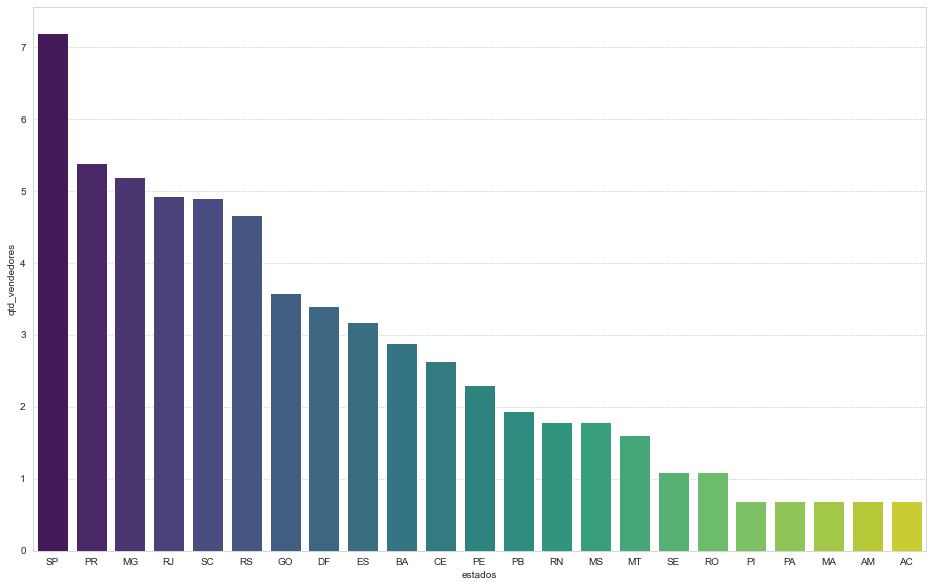

In [54]:
plt.figure(figsize=(16, 10))
sns.barplot(x='estados', y='qtd_vendedores', data=seller_state, palette='viridis')
plt.show()

## 8. Quantidade de pedidos por status de pedido

> Consulta SQL.

In [55]:
!sqlite3 olist.db '.tables'

olist_customers       olist_order_payments  olist_products      
olist_geolocation     olist_order_reviews   olist_sellers       
olist_order_items     olist_orders        


In [56]:
query = """
        SELECT order_status AS status_pedidos, COUNT(DISTINCT customer_id) AS qtd_clientes

        FROM olist_orders

        GROUP BY order_status

        ORDER BY qtd_clientes DESC
        
        """

order_status = pd.read_sql(query, con=conn)
order_status

,status_pedidos,qtd_clientes
0,delivered,96478
1,shipped,1107
2,canceled,625
3,unavailable,609
4,invoiced,314
5,processing,301
6,created,5
7,approved,2


## 9. Quantidade de pedidos entregues e quantidade de pedidos cancelados

> Consulta SQL.

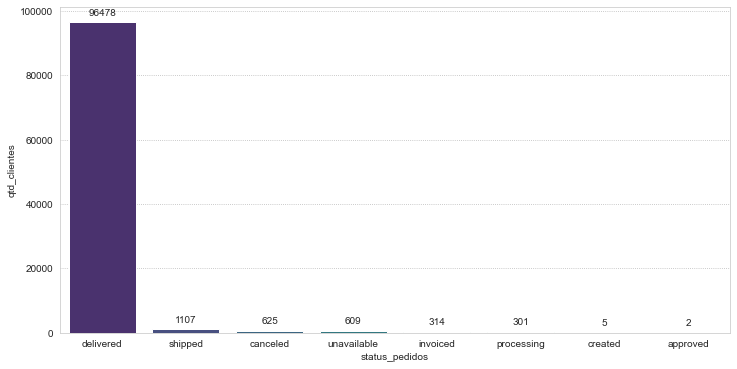

In [57]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(x='status_pedidos', y='qtd_clientes', palette= 'viridis', data=order_status)

for i in ax.containers:
    ax.bar_label(i, label_type="edge", padding=5)

plt.show()

In [58]:
query = """
        SELECT order_status AS status_pedidos, COUNT(DISTINCT customer_id) AS qtd_clientes

        FROM olist_orders

        WHERE order_status IN ('delivered','canceled')
        
        GROUP BY order_status

        ORDER BY qtd_clientes DESC
        
        """

order_status = pd.read_sql(query, con=conn)
order_status

,status_pedidos,qtd_clientes
0,delivered,96478
1,canceled,625


## 10.Quantidade de pedidos por tipo de pagamento

> Consulta SQL.

In [59]:
!sqlite3 olist.db '.tables'

olist_customers       olist_order_payments  olist_products      
olist_geolocation     olist_order_reviews   olist_sellers       
olist_order_items     olist_orders        


In [60]:
query = """
        SELECT COUNT(payment_sequential) AS qtd_pedidos, payment_type AS tipos_pagamentos
        
        FROM olist_order_payments
        
        GROUP BY payment_type
        
        ORDER BY qtd_pedidos DESC
        
        """

order_payments = pd.read_sql(query, con=conn)
order_payments

,qtd_pedidos,tipos_pagamentos
0,76795,credit_card
1,19784,boleto
2,5775,voucher
3,1529,debit_card
4,3,not_defined


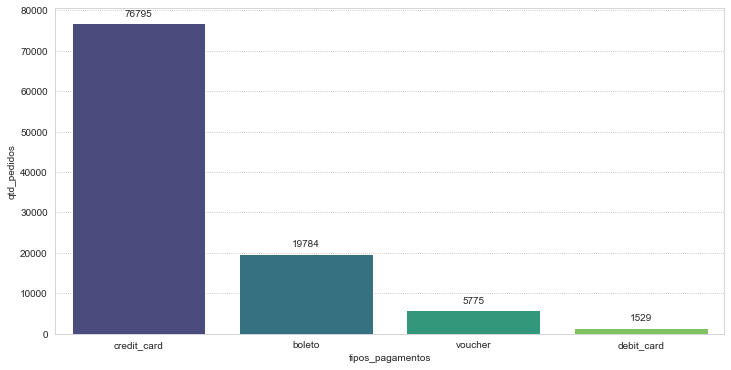

In [61]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(x='tipos_pagamentos', y='qtd_pedidos',palette= 'viridis', data=order_payments.loc[:3])

for i in ax.containers:
    ax.bar_label(i, label_type="edge", padding=5)
    
plt.show()

## 11. Preço máximo, mínimo e médio dos valores de pedidos feitos com cartão de crédito

> Consulta SQL.

In [62]:
!sqlite3 olist.db '.tables'

olist_customers       olist_order_payments  olist_products      
olist_geolocation     olist_order_reviews   olist_sellers       
olist_order_items     olist_orders        


In [63]:
query = """
        SELECT MAX(payment_value) AS valor_maximo, ROUND(MIN(payment_value),2) AS valor_minimo, ROUND(AVG(payment_value),2) AS valor_medio
        FROM olist_order_payments
        WHERE payment_type == 'credit_card'
        """

order_values = pd.read_sql(query, con=conn)
order_values

,valor_maximo,valor_minimo,valor_medio
0,13664.08,0.01,163.32


## 12. Média do frete por categoria do produto

> Consulta SQL.

In [64]:
!sqlite3 olist.db '.tables'

olist_customers       olist_order_payments  olist_products      
olist_geolocation     olist_order_reviews   olist_sellers       
olist_order_items     olist_orders        


In [65]:
query = """
        SELECT p.product_category_name AS categoria_produto, ROUND(AVG(oi.freight_value),2) AS media_frete

        FROM olist_products p INNER JOIN olist_order_items oi ON p.product_id = oi.product_id

        GROUP BY p.product_category_name

        ORDER BY oi.freight_value DESC
        
        """

order_freight = pd.read_sql(query, con=conn)
order_freight = order_freight.sort_values(by= 'media_frete', ascending = False)
order_freight.head(15)

,categoria_produto,media_frete
0,pcs,48.45
23,eletrodomesticos_2,44.54
8,moveis_colchao_e_estofado,42.91
57,moveis_cozinha_area_de_servico_jantar_e_jardim,42.70
13,moveis_quarto,42.50
5,moveis_escritorio,40.55
2,portateis_casa_forno_e_cafe,36.16
4,moveis_sala,35.72
32,sinalizacao_e_seguranca,32.70
11,industria_comercio_e_negocios,29.42


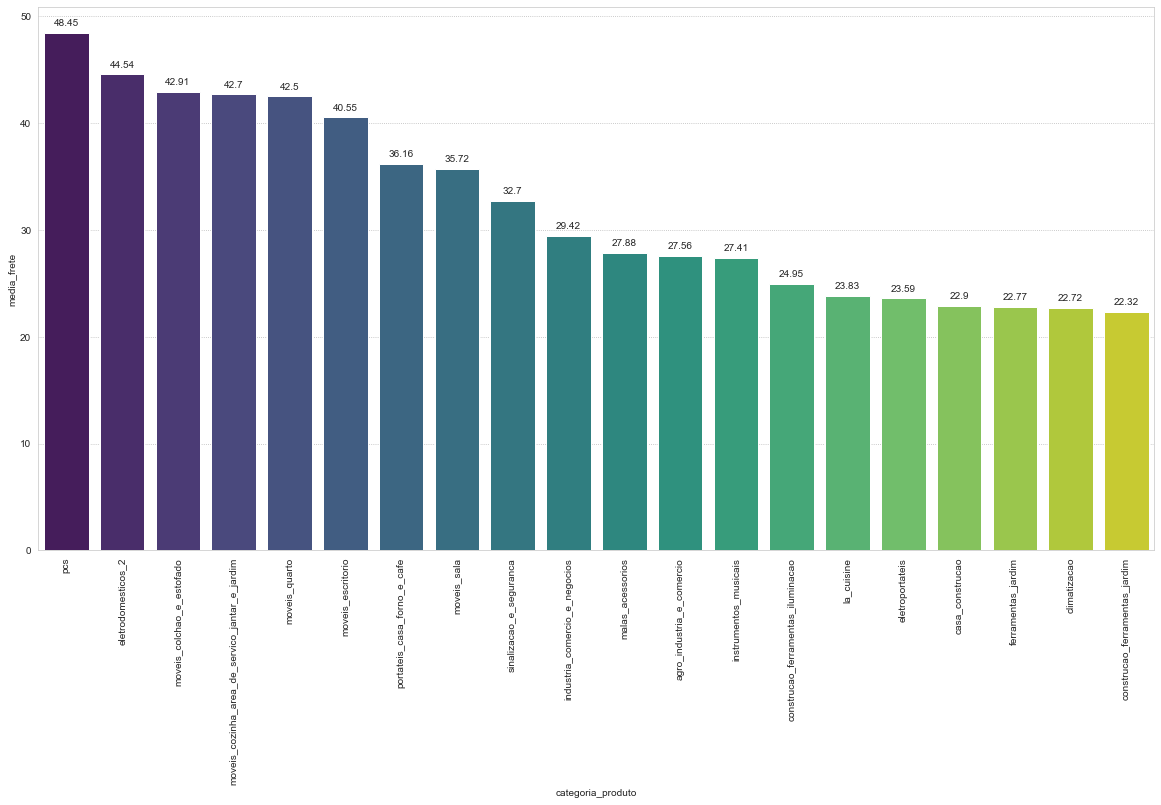

In [66]:
plt.figure(figsize=(20, 10))

ax = sns.barplot(x='categoria_produto', y='media_frete', palette= 'viridis', data=order_freight.loc[:10])

plt.xticks(rotation=90)

for i in ax.containers:
    ax.bar_label(i, label_type="edge", padding=5)
    
plt.show()

## 13. Total de pedidos cadastrados 

> Consulta SQL.

In [67]:
!sqlite3 olist.db '.tables'

olist_customers       olist_order_payments  olist_products      
olist_geolocation     olist_order_reviews   olist_sellers       
olist_order_items     olist_orders        


In [68]:
query = """
        SELECT COUNT(DISTINCT customer_id) AS total_pedidos

        FROM olist_orders
        
        """

orders = pd.read_sql(query, con=conn)
orders

,total_pedidos
0,99441


## 14. Distribuição de reviews dos pedidos

> Consulta SQL.

In [69]:
!sqlite3 olist.db '.tables'

olist_customers       olist_order_payments  olist_products      
olist_geolocation     olist_order_reviews   olist_sellers       
olist_order_items     olist_orders        


In [70]:
query = """
        SELECT review_score, COUNT(order_id) AS reviews_clientes

        FROM olist_order_reviews

        GROUP BY review_score

        ORDER BY reviews_clientes DESC
        
        """

order_reviews = pd.read_sql(query, con=conn)
order_reviews

,review_score,reviews_clientes
0,5,57328
1,4,19142
2,1,11424
3,3,8179
4,2,3151


In [71]:
mean = order_reviews['review_score'].mean()
std = order_reviews['review_score'].std() 

In [72]:
mean, np.round(std,2)

(3.0, 1.58)

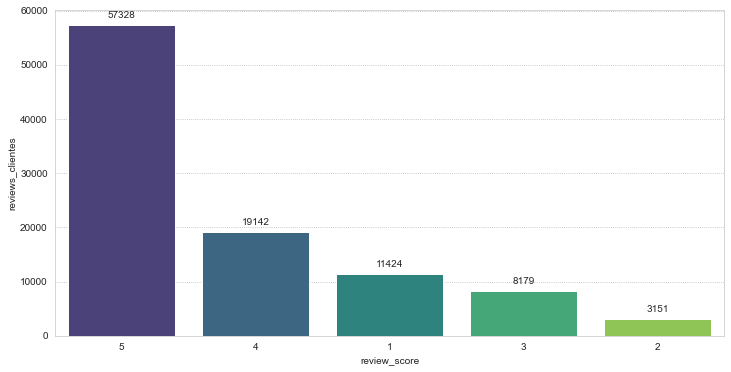

In [73]:
order_reviews2 = order_reviews.sort_values(by='reviews_clientes', ascending=False)

score_order = [5, 4, 1, 3, 2]

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='review_score', y='reviews_clientes', palette= 'viridis', data=order_reviews, order=score_order)

for i in ax.containers:
    ax.bar_label(i, label_type='edge', padding=5)

plt.show()

## 15. Ano em que mais enviou produtos

> Consulta SQL.

In [74]:
!sqlite3 olist.db '.tables'

olist_customers       olist_order_payments  olist_products      
olist_geolocation     olist_order_reviews   olist_sellers       
olist_order_items     olist_orders        


In [75]:
query = """
        SELECT strftime('%Y', shipping_limit_date) AS ano_envio, COUNT(DISTINCT product_id) AS qtd_produtos
        FROM olist_order_items
        GROUP BY strftime('%Y', shipping_limit_date)
        ORDER BY qtd_produtos DESC
        LIMIT 1000;
        """

order_year = pd.read_sql(query, con=conn)
order_year

,ano_envio,qtd_produtos
0,2018,20747
1,2017,17003
2,2016,277
3,2020,3


In [76]:
order_year = order_year.sort_values(by= 'ano_envio', ascending=True)

<AxesSubplot: xlabel='ano_envio', ylabel='qtd_produtos'>

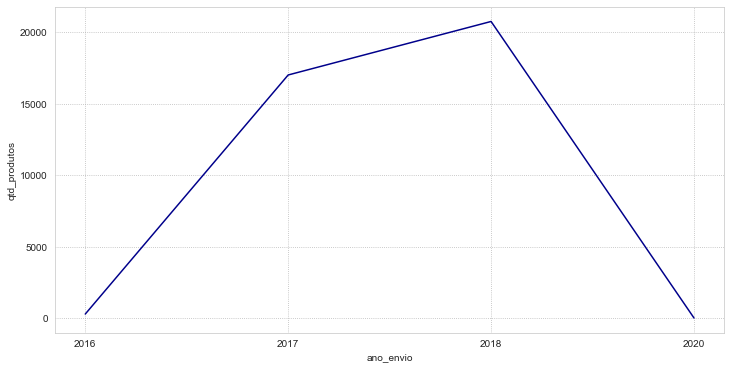

In [77]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=order_year, x='ano_envio', y='qtd_produtos', color='darkblue')

In [78]:
olist_order_items['shipping_limit_date'].max()

'2020-04-09 22:35:08'

OBS: os registros do ano de 2020 são até abril, por isso nao dá para dizer que houve diminuição de 2018 a 2020.

# Fechando a conexão com o banco de dados

In [79]:
conn.close()